In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### ID de las particulas a z=0 Gadget

In [13]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo

vector = ('00','01','03')
vector2 = ('M31', 'MW', 'M33')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

# path = '/home/ornela/SimCLUES/'
path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
aexp = aexp[::-1]

path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,495,-1)

for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,3):
        cm   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s'%vector[i])+ '/R200'].value
        
        pstr  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        mstr  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Masses'].value
        vel   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Velocities'].value
        IDs   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Ids'].value
        tform = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/FormationTime'].value
        
        z = a0/tform - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        tform = tiempo.conv(z, h, omega_lambda, omega_matter)  
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[0]/h
        ystr = (pstr[:,1]-cm[1])*aexp[0]/h
        zstr = (pstr[:,2]-cm[2])*aexp[0]/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        r200 = r200*aexp[0]/h
        
        rgal=0.15*r200
        
        limit, = np.where(rstr<rgal)
        
        rn = rstr[limit]
        ID = IDs[limit]
        tf = tform[limit]
        
#----------------------------------------------------------------------------------

        data = np.zeros([np.size(rn),3])
        data[:,0]= ID
        data[:,1]= rn
        data[:,2]= tf
        
        
        np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_tform_z0.dat', data, fmt=('%15d','%12.6f','%12.6f'))

## Particulas de la barra a z = 0

186589


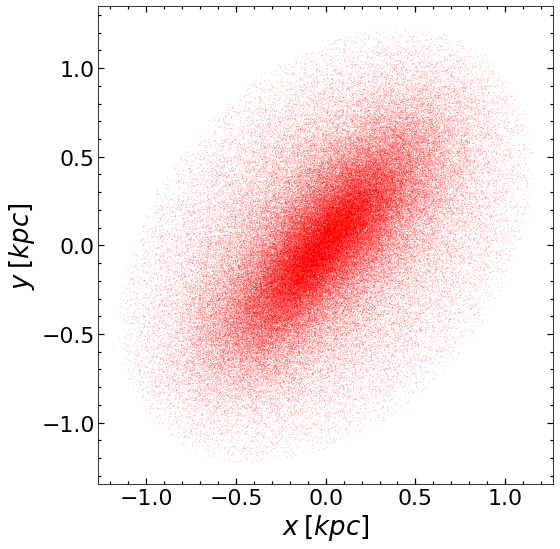

In [14]:
import h5py
import rotation_mio as rot
import barstrength2 as strng
import time_conversion as tiempo
import tenform as ten
from numpy import linalg


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------
path = '/home/omarioni/'

aa = np.loadtxt(path + 'redshift_outputs.txt')
aexp = aa[:,2]

M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_A2max_time.dat')
phim_M31gd  = M31_gd[:,2][0]

M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime2.dat')
lbar_M31gd = M31_gd[:,1][0]

snapshot=range(496,495,-1) #SNAPSHOTS
i=0

path = '/mnt/is2/alejandro/ornella/'


for isnap in snapshot:
    
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm    = snap['subhalo_000/Center'].value
    r200  = snap['subhalo_000/R200'].value
    IDs   = snap['subhalo_000/Str/Ids'].value
    formt = snap['subhalo_000/Str/FormationTime'].value
    pstr  = snap['subhalo_000/Str/Coordinates'].value
    mstr  = snap['subhalo_000/Str/Masses'].value
    vel   = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)
    
    aux   = a0/formt - 1.
    tform = tiempo.conv(aux, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.


    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    cincuenta, = np.where(razon < 0.5)

    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    
#-----------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn  = np.sqrt(xn**2 + yn**2 + zn**2)
    
    
    xx = xn*cos(phim_M31gd)+yn*sin(phim_M31gd)
    yy = xn*-sin(phim_M31gd)+yn*cos(phim_M31gd)
    zz = zn
    
    #----para lbar2--------------------------------------------------------------
    limit1,=np.where(r < lbar_M31gd)
    tensor = ten.tenf(xx[limit1], yy[limit1], zz[limit1])

    matriz = linalg.eig(tensor)
    autov  = matriz[0]

    asort  = np.sort(autov)

    a1 = asort[2]
    b1 = asort[1]
    c1 = asort[0]
    
    A1 = np.sqrt(a1)
    B1 = np.sqrt(b1)
    C1 = np.sqrt(c1)

    
#Definimos el tamaño de nuestro elipsoide
    aa=lbar_M31gd
    bb=(B1/A1)*lbar_M31gd
    cc=(C1/A1)*lbar_M31gd
    
#Hacemos la rotación de las coordenadas

    RR = np.sqrt((xx/aa)**2+(yy/bb)**2+(zz/cc)**2) # formula del elipsoide
    
    mask, = np.where(RR<1) #seleccionamos las particulas dentro del elipsoide
    
    ID    = IDs[mask]
    tform = tform[mask]
    rn_z0 = rn[mask]
    
    print len(ID)
    
# Guargamos los parámetros en distintos archivos
# ----------------------------------------------------------------------------------
    datos = np.ndarray([len(ID),3])
    datos[:,0] = ID
    datos[:,1] = tform
    datos[:,2] = rn_z0

    np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/M31_part_barra.dat', datos, fmt=('%15d' '%12.6f' '%12.6f'))
    
#----------------------------------------------------------------------------------  
    
    fig=plt.figure(1, figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax=fig.add_subplot(111)
#     ax.plot(xn,yn,'.', markersize=0.1, color='k')
    ax.plot(xn[mask],yn[mask],'.', markersize=0.1, color='r')
#     ax.set_xlim(-5,5)
#     ax.set_ylim(-5,5)
    ax.minorticks_on()
    ax.tick_params( labelsize=22)
    ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')  
    ax.set_xlabel(r'$x\:[kpc]$', fontsize=26)
    ax.set_ylabel(r'$y\:[kpc]$',fontsize=26)
    plt.show()

### Guardamos las coordenadas del centro de masa para cada tiempo - GADGET

In [7]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import time_conversion as tiempo

vector = ('00','01','03')
vector2 = ('M31', 'MW', 'M33')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

# path = '/home/ornela/SimCLUES/'
path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]

path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,0,-1)

for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,3):
        cm   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Center'].value
         
        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)  

#----------------------------------------------------------------------------------

        path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
        archivo1 =  open(path2 + str('%s'%vector2[i])+'_masscenter.dat','a')
        archivo1.write(str('%12.6f'% time) +'\t'+
                str('%12.6f'% cm[0]) +'\t'+
                str('%12.6f'% cm[1]) +'\t'+
                str('%12.6f'% cm[2]) +'\n')
        archivo1.close()

### Guardamos las coordenadas del centro de masa para cada tiempo - GASOLINE

In [3]:
import h5py

vector = (1,2,4)
vector2 = ('M31', 'MW', 'M33')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

path= '/mnt/sersic2/omarioni/'
snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')

path2 = '/home/omarioni/Barras_GdGs/Barras_Gs/_data/'

for j in range(len(snapshot)-1,0,-1):
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    for i in range(0,3):
        cm   = snap['subhalo_00'+ str('%s'%vector[i])+ '/Center'].value
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
        
#----------------------------------------------------------------------------------
        archivo1 =  open(path2 + str('%s'%vector2[i])+'_masscenter.dat','a')
        archivo1.write(str('%12.6f'% time) +'\t'+
                str('%12.6f'% cm[0]) +'\t'+
                str('%12.6f'% cm[1]) +'\t'+
                str('%12.6f'% cm[2]) +'\n')
        archivo1.close()